In [28]:
import pandas as pd
import numpy as np
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [29]:
df = pd.read_csv("dataset/oasis_longitudinal.csv")
df.drop(columns=["Subject ID", "MRI ID", "Hand"], inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    object 
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    object 
 4   Age       373 non-null    int64  
 5   EDUC      373 non-null    int64  
 6   SES       354 non-null    float64
 7   MMSE      371 non-null    float64
 8   CDR       373 non-null    float64
 9   eTIV      373 non-null    int64  
 10  nWBV      373 non-null    float64
 11  ASF       373 non-null    float64
dtypes: float64(5), int64(5), object(2)
memory usage: 35.1+ KB


In [31]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [32]:
# Remove missing vals, outliers, scale data

# Could also do a mean or back/forward fill
df.dropna(inplace=True)

# Process categorical data (Group & M/F)
df['Group'].replace({'Demented': 1, 'Nondemented': 0})
map = pd.get_dummies(df['M/F'], prefix='is')
df = pd.concat([df, map], axis=1)
df.drop(columns='M/F', inplace=True)

# Removing outliers did not improve
# for feature in ['MR Delay', 'Age', 'EDUC', 'MMSE', 'eTIV', 'nWBV', 'ASF']:
#     datapoints = df[feature]
#     mean = datapoints.mean()
#     std = datapoints.std()
#     outliers = (datapoints < mean-3*std) | (datapoints > mean+3*std)
#     df.drop(index=df[outliers].index, inplace=True)

df

,Group,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,is_F,is_M
0,Nondemented,1,0,87,14,2.0,27.0,0.0,1987,0.696,0.883,False,True
1,Nondemented,2,457,88,14,2.0,30.0,0.0,2004,0.681,0.876,False,True
5,Nondemented,1,0,88,18,3.0,28.0,0.0,1215,0.710,1.444,True,False
6,Nondemented,2,538,90,18,3.0,27.0,0.0,1200,0.718,1.462,True,False
7,Nondemented,1,0,80,12,4.0,28.0,0.0,1689,0.712,1.039,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,2,842,82,16,1.0,28.0,0.5,1693,0.694,1.037,False,True
369,Demented,3,2297,86,16,1.0,26.0,0.5,1688,0.675,1.040,False,True
370,Nondemented,1,0,61,13,2.0,30.0,0.0,1319,0.801,1.331,True,False
371,Nondemented,2,763,63,13,2.0,30.0,0.0,1327,0.796,1.323,True,False


In [33]:
y = df['Group']
X = df.drop(columns='Group')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=156)

In [34]:
# This bumps logistic regression up a percent and now makes KNN usable
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) # Do visits need to be scaled?
X_test = scaler.transform(X_test)

Logistic Regression

In [35]:
scorings = []
loocv = LeaveOneOut()

for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
    model = LogisticRegression(solver=solver)
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=loocv))
    scorings.append({solver: score})
    
scorings

/home/brayner/MSCI446/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/brayner/MSCI446/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/brayner/MSCI446/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/brayner/MSCI446/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/brayner/MSCI446/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/brayner/MSCI446/.venv/lib/python3.

[{'lbfgs': 0.9081272084805654},
 {'liblinear': 0.9045936395759717},
 {'newton-cg': 0.9081272084805654},
 {'newton-cholesky': 0.9081272084805654},
 {'sag': 0.9081272084805654},
 {'saga': 0.9081272084805654}]

In [36]:
model = LogisticRegression(solver='lbfgs') # best solver
model.fit(X_train, y_train)
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.9014084507042254

In [37]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.13) # Compare select C values
model.fit(X_train, y_train)
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.9154929577464789

<Axes: xlabel='penalty'>

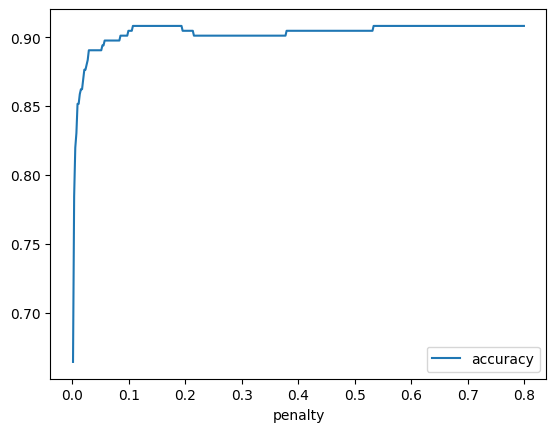

In [38]:
accuracy = []
loocv = LeaveOneOut()

for penalty in np.arange(0.001,0.8,0.002):
    model = LogisticRegression(solver='lbfgs', penalty='l2', C=penalty) # Compare select C values
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=loocv))
    accuracy.append(score)

df = pd.DataFrame()
df['penalty'] = np.arange(0.001,0.8,0.002)
df['accuracy'] = accuracy
df.plot(x='penalty')

<Axes: xlabel='penalty'>

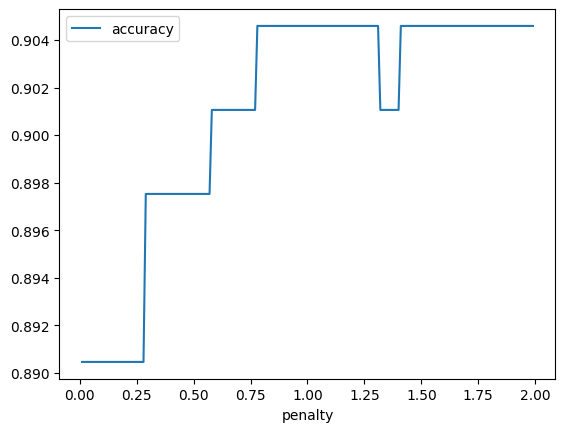

In [39]:
accuracy = []

for penalty in np.arange(0.01,2,0.01):
    model = LogisticRegression(solver='liblinear', penalty='l1', C=penalty) # Compare select C values
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=loocv))
    accuracy.append(score)

df = pd.DataFrame()
df['penalty'] = np.arange(0.01,2,0.01)
df['accuracy'] = accuracy
df.plot(x='penalty')

Guassian

In [40]:
model = GaussianNB()
model.fit(X_train, y_train)
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.8873239436619719

KNN

In [41]:
model = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': range(2,25)})
model.fit(X_train, y_train)
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.8450704225352113

<Axes: xlabel='k'>

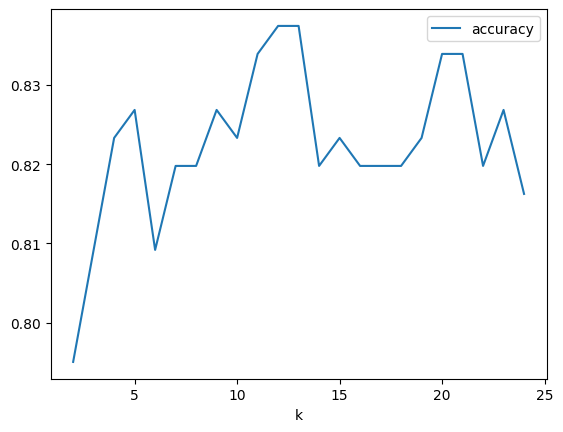

In [46]:
accuracy = []
loocv = LeaveOneOut()

for k in range(2,25):
    model = KNeighborsClassifier(n_neighbors=k)
    score = np.mean(cross_val_score(model, X_train, y_train, scoring='accuracy', cv=loocv))
    accuracy.append(score)

df = pd.DataFrame()
df['k'] = range(2,25)
df['accuracy'] = accuracy
df.plot(x='k')

In [45]:
model = KNeighborsClassifier(n_neighbors=12)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.8450704225352113